In [41]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from datetime import datetime
from tqdm import tqdm
import rasterio

from datasets import HousingDataset
from model import Model
from utils import Select, CustomScale

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cuda


In [85]:
mean=np.array([1377, 1354, 1381, 2356])
std=np.array([540, 398, 327, 515])

upperbound = mean + 3 * std
SCALE = upperbound[:, np.newaxis, np.newaxis]

norm_mean = mean / upperbound
norm_std = std / upperbound
    
transformations = [
    transforms.CenterCrop(size=(32, 32)), 
    CustomScale(scale=1/SCALE, clamp=(0, 1.0)),
    transforms.Normalize(mean=norm_mean, std=norm_std),
    Select(dim=-3, indices=[0,1,2]),
]
transform = transforms.Compose(transformations)

reverse_transform = transforms.Compose([
    transforms.Normalize(mean=-norm_mean[:3]/norm_std[:3], std=1/norm_std[:3]), 
    CustomScale(scale=SCALE[:3], clamp=None),
])

In [4]:
train_set = HousingDataset("/atlas/u/erikrozi/housing_event_pred/data/train_seasonal_eff.csv", transform=transform)
print(len(train_set))
val_set = HousingDataset("/atlas/u/erikrozi/housing_event_pred/data/val_seasonal_eff.csv", transform=transform)
print(len(val_set))
test_set = HousingDataset("/atlas/u/erikrozi/housing_event_pred/data/test_seasonal_eff.csv", transform=transform)
print(len(test_set))

25071
1411
1422


In [5]:
# toy_indices = list(np.random.choice(np.arange(len(train_set)), size=(100,), replace=False))
# train_set = torch.utils.data.Subset(train_set, toy_indices)
# val_indices = list(np.random.choice(np.arange(len(val_set)), size=(100,), replace=False))
# val_set = torch.utils.data.Subset(val_set, val_indices)

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False, num_workers=8)

In [7]:
encoder = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,1,padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(16),
    torch.nn.Conv2d(16,32,1,padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.BatchNorm2d(32),
    torch.nn.Conv2d(32,64,1,padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(64),
    torch.nn.Conv2d(64,128,1,padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.BatchNorm2d(128),
).to(device=device)

# torchvision.models.resnet18(pretrained=True).to(device=device)
# encoder.layer4 = torch.nn.Identity()
# encoder.avgpool = torch.nn.Identity()
# encoder.fc = torch.nn.Identity()

# import sys
# sys.path.append("../housing_event_pred/models")
# import resnet_cifar
# encoder = resnet_cifar.ResNet18(img_channels=3).to(device=device)
# encoder.avgpool = torch.nn.Identity()
# encoder.fc = torch.nn.Identity()

In [8]:
model = Model(encoder).to(device=device).eval()

# Evaluate model

In [9]:
!ls -l checkpoints/exp_2022-04-08T22:47:25Z | grep ckpt_2..\.pt

-rw-r--r-- 1 pliu1 users 48036275 Apr 10 21:15 ckpt_195.pt
-rw-r--r-- 1 pliu1 users 48036275 Apr 10 21:30 ckpt_196.pt
-rw-r--r-- 1 pliu1 users 48036275 Apr 10 21:44 ckpt_197.pt
-rw-r--r-- 1 pliu1 users 48036275 Apr 10 21:58 ckpt_198.pt
-rw-r--r-- 1 pliu1 users 48036275 Apr 10 22:13 ckpt_199.pt


In [10]:
model.load_state_dict(torch.load('checkpoints/exp_2022-04-08T22:47:25Z/ckpt_200.pt', map_location=device))

<All keys matched successfully>

## Evaluate by random sampling val points

In [27]:
def predict(model, dset, loops=1):
    model.eval()
    dloader = torch.utils.data.DataLoader(dset, batch_size=32, shuffle=False)
    predictions = []
    labels = []
    for l in range(loops):
        for i, batch in enumerate(tqdm(dloader, desc=f"Loop {l}/{loops}")):
            with torch.no_grad():
                img_start = batch["image_start"].to(device=device).float()
                img_end = batch["image_end"].to(device=device).float()
                img_sample = batch["image_sample"].to(device=device).float()
                label = batch["label"].float().to(device=device)

                pred = model(img_start, img_end, img_sample).flatten()
                predictions.append(pred.detach().cpu().numpy())
                labels.append(label.flatten().cpu().numpy())
    return np.concatenate(predictions), np.concatenate(labels).astype(int)

In [31]:
predictions, labels = predict(model, val_set, loops=1)

Loop 0/1: 100%|███████████████████████████████| 784/784 [51:28<00:00,  3.94s/it]


In [33]:
predictions = (predictions > 0.5)
accurate = np.sum(labels == predictions)
total = len(labels)
print(f"Accuracy {accurate} / {total} = {accurate/total}")

Accuracy 25006 / 25071 = 0.9974073630888277


In [34]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12543
           1       1.00      1.00      1.00     12528

    accuracy                           1.00     25071
   macro avg       1.00      1.00      1.00     25071
weighted avg       1.00      1.00      1.00     25071



## Evaluate conditioned on start and end

In [35]:
df = pd.read_csv("/atlas/u/erikrozi/housing_event_pred/data/val_seasonal_eff.csv")

In [129]:
# TODO: Generate all predictions together (maybe with ends as well), and keep a build/label mask
df = df[df["year.built"].isin([2017, 2018])]
T_start = (2016, 1)
T_end = (2019, 10)
labels = []
predictions = []
build_predictions = []
S = (lambda x: x.index(T_end) - x.index(T_start) - 5)(
    [(year, month) for year in range(T_start[0], T_end[0]+1) for month in range(1, 12, 3)])
model.eval()
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    year_built = row["year.built"]
    before_times = [(year, month) for year in range(T_start[0], year_built) for month in range(1, 12, 3)]
    before_times = before_times[before_times.index(T_start)+1:]
    built_times = [(year_built, month) for month in range(1, 12, 3)]
    after_times = [(year, month) for year in range(year_built+1, T_end[0]+1) for month in range(1, 12, 3)]
    after_times = after_times[:after_times.index(T_end)]
    sample_times = before_times + after_times + built_times
    label = [0] * len(before_times) + [1] * len(after_times)
    col_names = [f"sentinel_{y}_{(m - 1) // 3 + 1}" for y, m in [T_start, T_end] + sample_times]
    image_files = row[col_names].tolist()
    images = torch.FloatTensor(np.array([rasterio.open(name).read() for name in image_files])) 
    with torch.no_grad():
        images = transform(images)
        img_start = images[0].repeat(len(sample_times), 1, 1, 1).to(device=device).float()
        img_end = images[1].repeat(len(sample_times), 1, 1, 1).to(device=device).float()
        img_sample = images[2:].to(device=device).float()
        pred = model(img_start, img_end, img_sample).flatten().cpu().numpy()
        predictions.append(pred[:-4])
        build_predictions.append(pred[-4:])
        labels.append(np.array(label))
predictions = np.array(predictions)
build_predictions = np.array(build_predictions)
labels = np.array(labels)

100%|███████████████████████████████████████| 1411/1411 [14:28<00:00,  1.62it/s]


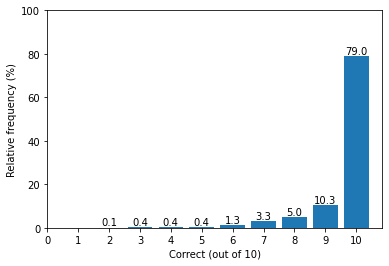

In [130]:
predictions = (predictions > 0.5)
accurate = (predictions == labels)
acc_counts = np.sum(accurate, axis=1)
acc, counts = np.unique(acc_counts, return_counts=True)
freqs = counts / labels.shape[0]

fig, ax = plt.subplots()
ax.set_ylim(bottom=0, top=100)
p = ax.bar(acc, 100 * freqs)
ax.bar_label(p, label_type='edge', fmt='%.1f')
ax.set_xticks(range(S+1))
ax.set_xlabel(f"Correct (out of {S})")
ax.set_ylabel(f"Relative frequency (%)")
plt.show()

In [131]:
print("Accuracy by majority vote per time series:", np.sum(acc_counts >= 6) / labels.shape[0])

Accuracy by majority vote per time series: 0.9872430900070872


In [156]:
# Pattern of predictions per build year
build_pred_pattern, build_pred_count = np.unique(1 * (build_predictions > 0.5), axis=0, return_counts=True)
print("Pattern\t\tCount")
for i in range(build_pred_pattern.shape[0]):
    print(f"{build_pred_pattern[i]}\t{build_pred_count[i]}")

Pattern		Count
[0 0 0 0]	189
[0 0 0 1]	219
[0 0 1 0]	9
[0 0 1 1]	335
[0 1 0 0]	4
[0 1 0 1]	11
[0 1 1 0]	7
[0 1 1 1]	262
[1 0 0 0]	4
[1 0 0 1]	6
[1 0 1 0]	1
[1 0 1 1]	21
[1 1 0 0]	2
[1 1 0 1]	4
[1 1 1 0]	7
[1 1 1 1]	330


In [140]:
def show(idx, df, predictions, build_predictions):
    row = df.iloc[idx, :]
    year_built = row["year.built"]
    before_times = [(year, month) for year in range(T_start[0], year_built) for month in range(1, 12, 3)]
    before_times = before_times[before_times.index(T_start):]
    built_times = [(year_built, month) for month in range(1, 12, 3)]
    after_times = [(year, month) for year in range(year_built+1, T_end[0]+1) for month in range(1, 12, 3)]
    after_times = after_times[:after_times.index(T_end)+1]
    all_times = before_times + built_times + after_times
    label = [0] * len(before_times) + ["C"] * len(built_times) + [1] * len(after_times)
    label[0] = "S"
    label[-1] = "E"
    col_names = [f"sentinel_{y}_{(m - 1) // 3 + 1}" for y, m in all_times]
    image_files = row[col_names].tolist()
    images = torch.FloatTensor(np.array([rasterio.open(name).read() for name in image_files])) 
    images = reverse_transform(transform(images)).numpy()
    max_clamp = 3000
    gamma = 1.2
    images = np.clip(images, 0, max_clamp)
    images = (255 * (images / max_clamp)**(1/gamma)).astype(np.uint8)
    B, C, H, W = images.shape
    pred = predictions[idx]
    build_pred = build_predictions[idx]

    plt.figure(figsize=(15, 10))
    img_per_row = 6
    canvas = np.ones((H, W*img_per_row + 10*img_per_row - 10, C)) * 255
    left = 0
    x = []
    pred_i = 0
    build_pred_i = 0
    for i in range(len(all_times)):
        canvas[:, left:left+W, :] = images[i].transpose((1,2,0))
        xlabel = f"{all_times[i][0]}/{all_times[i][1]}"
        if label[i] == "S":
            xlabel += "\n*START*"
        elif label[i] == "E":
            xlabel += "\n*END*"
        elif label[i] == "C":
            xlabel += "\n*BUILD*"
            p = 1 * (build_pred[build_pred_i] > 0.5)
            xlabel += "\npred=" + str(p)
            build_pred_i += 1
        else:
            p = 1 * (pred[pred_i] > 0.5)
            if p == label[i]: # Correct
                xlabel += "\nCorrect"
            else: # Incorrect
                xlabel += "\nWrong"
                canvas[:, left:left+2, :] = [200,0,0]
                canvas[:, left+W-2:left+W, :] = [200,0,0]
                canvas[:2, left:left+W, :] = [200,0,0]
                canvas[-2:, left:left+W, :] = [200,0,0]
            xlabel += "\npred=" + str(p)
            pred_i += 1    
        x.append((left + W // 2, xlabel))
        left += W + 10

        if (i + 1) % img_per_row == 0 or i == len(all_times) - 1:
            xticks, xlabels = zip(*x)
            plt.xticks(ticks=xticks, labels=xlabels, fontsize=15)
            plt.imshow(canvas.astype(np.uint8))
            plt.show()
        if (i + 1) % img_per_row == 0:
            plt.figure(figsize=(15, 10))
            left = 0
            x = []
            canvas = np.ones((H, W*img_per_row + 10*img_per_row - 10, C)) * 255

idx 6


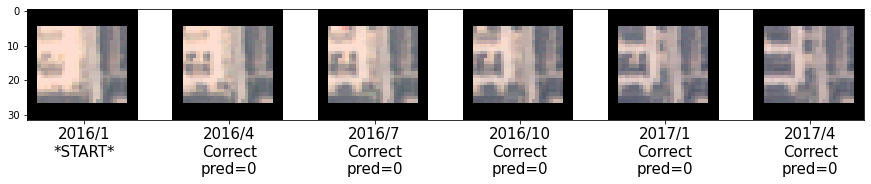

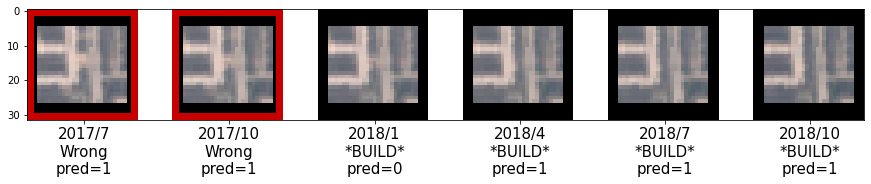

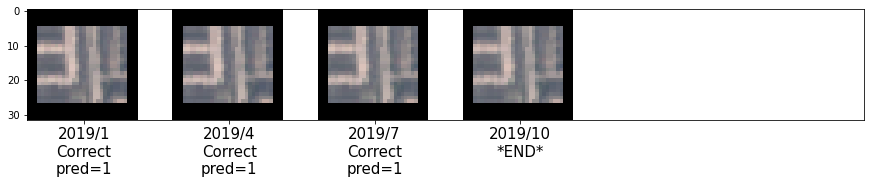

idx 27


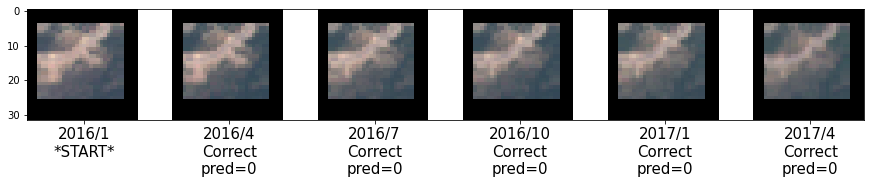

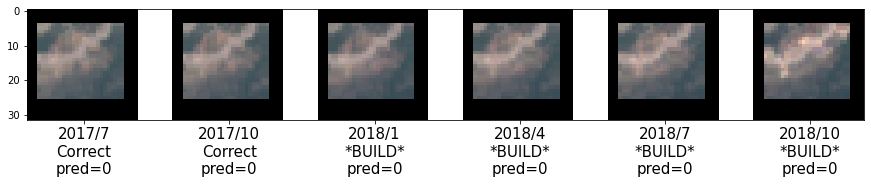

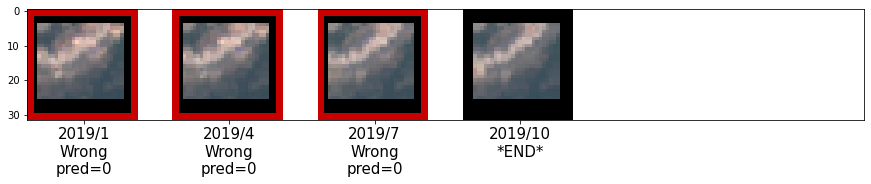

idx 30


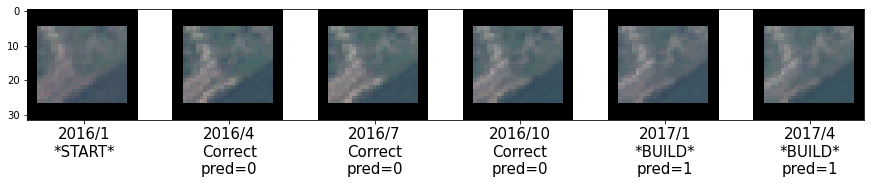

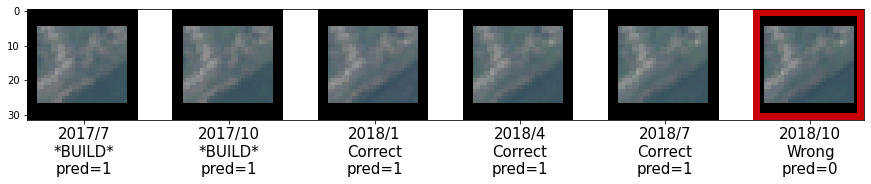

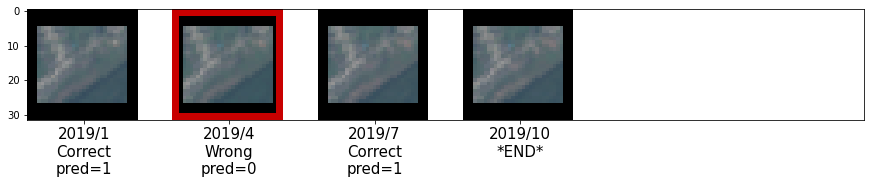

idx 36


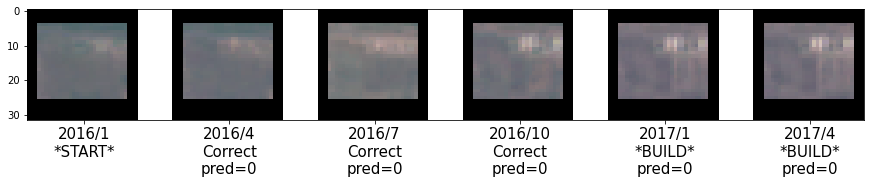

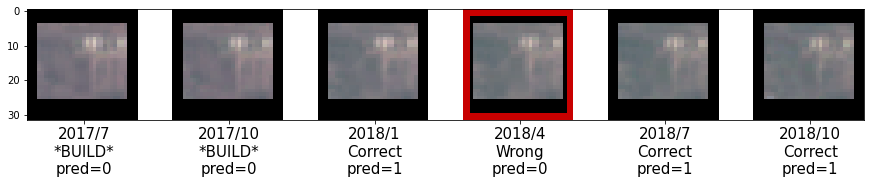

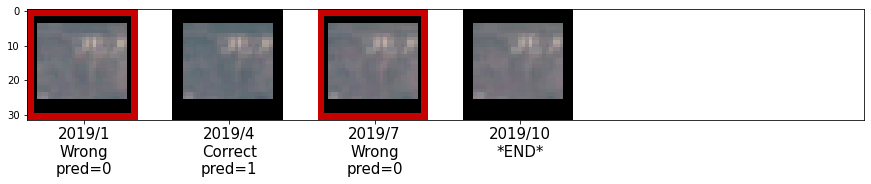

idx 47


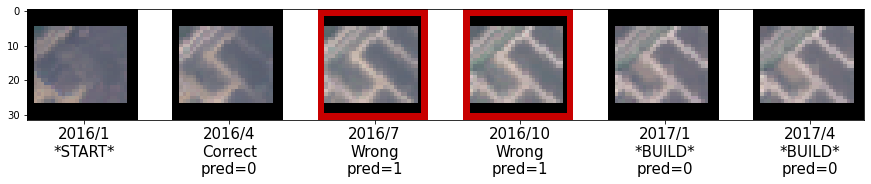

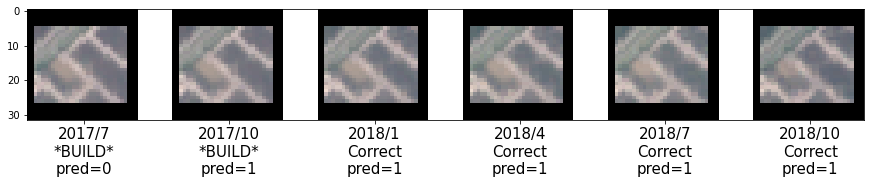

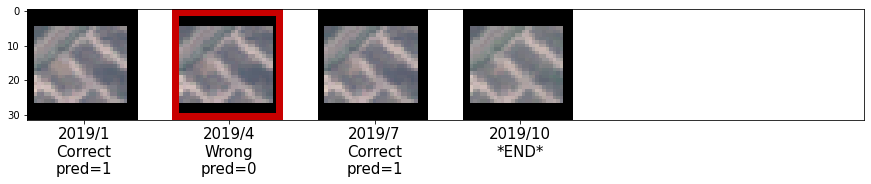

In [146]:
for idx in list(np.argwhere(acc_counts <= 8).flatten())[:5]:
    print("idx", idx)
    show(idx, df, predictions, build_predictions)

# Visualize outputs

In [20]:
def show_batch(batch, reverse_transform=None, filter_fn=lambda x: True):
    def revert(images):
        max_clamp = 3000
        gamma = 1.2
        if reverse_transform:
            images = reverse_transform(images)
        images = images.permute((0,2,3,1)).cpu().numpy()
        images = np.clip(images, 0, max_clamp)
        return (255 * (images / max_clamp)**(1/gamma)).astype(np.uint8)
    
    B, C, H, W = batch["image_start"].shape
    image_start = revert(batch["image_start"])
    image_end = revert(batch["image_end"])
    image_sample = revert(batch["image_sample"])
    for i in range(B):
        if not filter_fn({k: v[i] for k, v in batch.items()}):
            continue
        print(f"{batch['id'][i].item()} {batch['region'][i]}: Label = {batch['label'][i].item()}", 
              (f"Pred = {batch['pred'][i].item()}" if "pred" in batch.keys() else ""))
        plt.figure(figsize=(15, 5))
        canvas = np.ones((H, W*3 + 40, C)) * 255
        left = 0
        canvas[:, left:left+W, :] = image_start[i]
        x = []
        x.append((left + W // 2, f"Start {batch['year_start'][i]} month {batch['month_start'][i]}"))
        left += W+10
        if batch["label"][i] == 0:
            canvas[:, left:left+W, :] = image_sample[i]
            x.append((left + W // 2, f"Sample {batch['year_sample'][i]} month {batch['month_sample'][i]}"))
            left += W+10
            canvas[:, left:left+10, :] = [128,0,0]
            x.append((left + 5, f"Built {batch['year_built'][i]}"))
            left += 20
        else:
            canvas[:, left:left+10, :] = [128,0,0]
            x.append((left + 5, f"Built {batch['year_built'][i]}"))
            left += 20
            canvas[:, left:left+W, :] = image_sample[i]
            x.append((left + W // 2, f"Sample {batch['year_sample'][i]} month {batch['month_sample'][i]}"))
            left += W+10
        canvas[:, left:left+W, :] = image_end[i]
        x.append((left + W // 2, f"End {batch['year_end'][i]} month {batch['month_end'][i]}"))
        
        xticks, xlabels = zip(*x)
        plt.xticks(ticks=xticks, labels=xlabels, fontsize=15)
        plt.imshow(canvas.astype(np.uint8))
        plt.show()

In [76]:
model.eval()
num_batches = 1
for i, batch in enumerate(val_loader, start=1):
    with torch.no_grad():
        img_start = batch["image_start"].to(device=device).float()
        img_end = batch["image_end"].to(device=device).float()
        img_sample = batch["image_sample"].to(device=device).float()
        label = batch["label"].float().to(device=device)

        pred = model(img_start, img_end, img_sample).flatten()
        batch["pred"] = pred
        show_batch(batch, reverse_transform=reverse_transform, 
                   filter_fn=lambda x: (x['label'].item() != round(x['pred'].item()))) # Filter for incorrect outputs
    if i >= num_batches:
        break